In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectPercentile, SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import skew
import numpy as np
from pathlib import Path
import matplotlib.patches as mpatches
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import joblib
import shap

sys.path.append('../../../')

from src.emotion.prediction.aggregates.train_classifier import HyperparaSearchClassifier
from src.emotion.prediction.aggregates.classifier import CLASSIFIER

%matplotlib inline
plt.style.use('ggplot')

# set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

/home/moritz/anaconda3/envs/emorec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset_small.csv')

In [3]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [4]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(103, 135)

In [5]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)

(103, 132)


In [6]:
# Detect outliers
# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)


(103, 132)
(103, 132)


In [7]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [40]:
def plot_correlation_matrix(matrix):    
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # convert the correlation matrix back to DataFrame for better readability
    corr_df = pd.DataFrame(corr_matrix, columns=matrix.columns, index=matrix.columns)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=1.5)
    #plt.figure(figsize=(5, 4))  # Increase figure size for better visibility
    sns.heatmap(corr_df, cmap="YlGnBu", annot=True, fmt=".2f") 
    
    path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/appendix/"
    image = path + "/perma_correlation.pdf"
    plt.savefig(image, bbox_inches='tight', dpi=300)

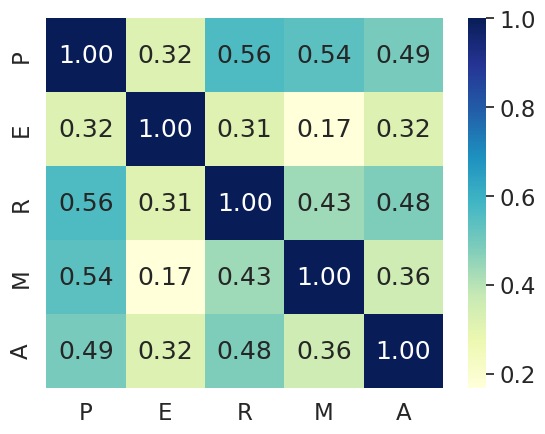

In [41]:
plot_correlation_matrix(Y)

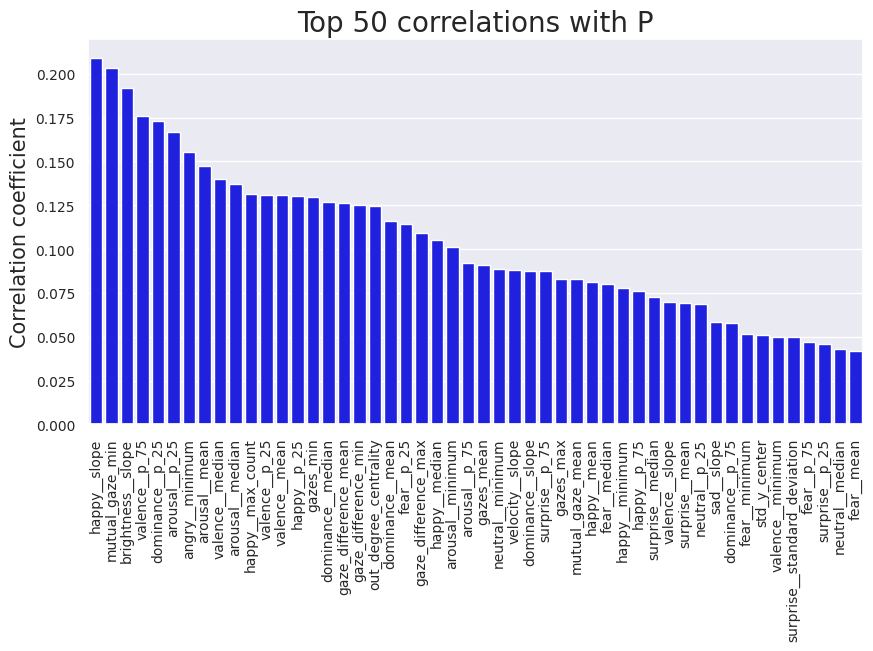

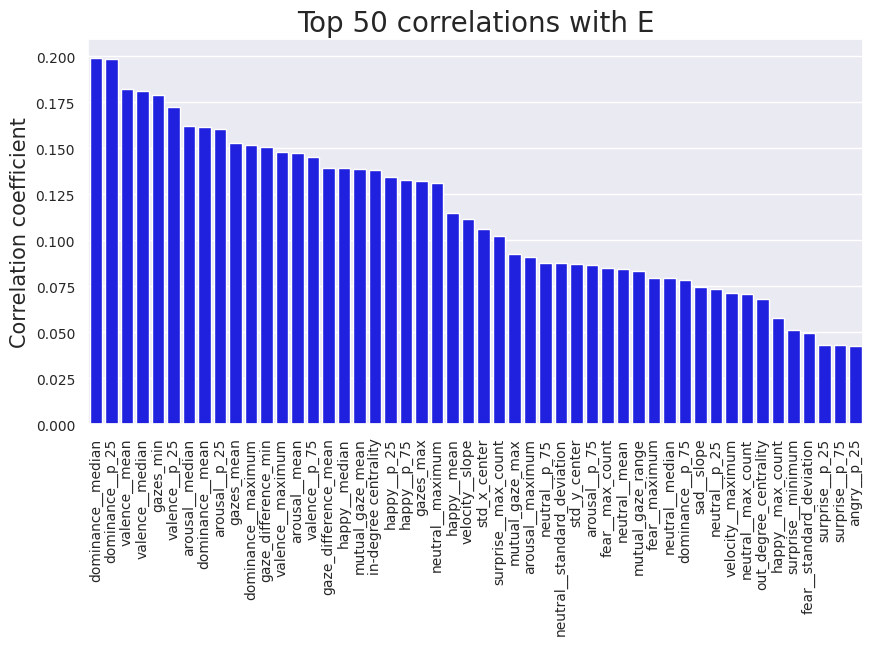

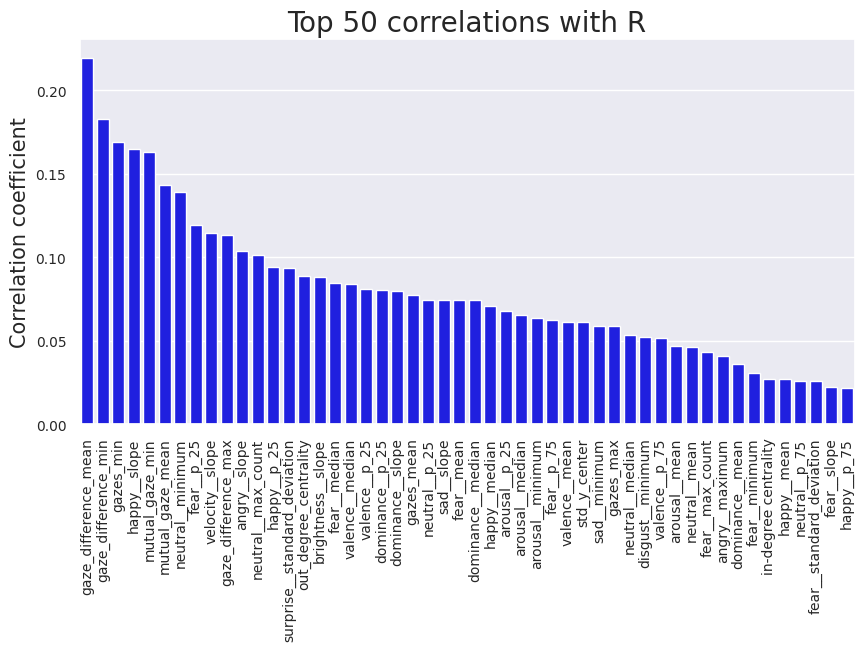

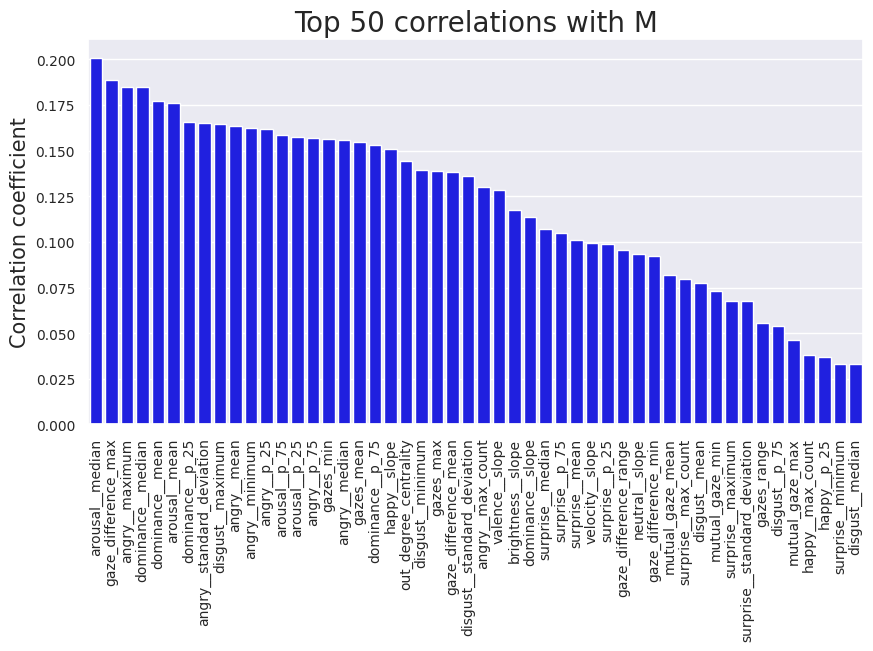

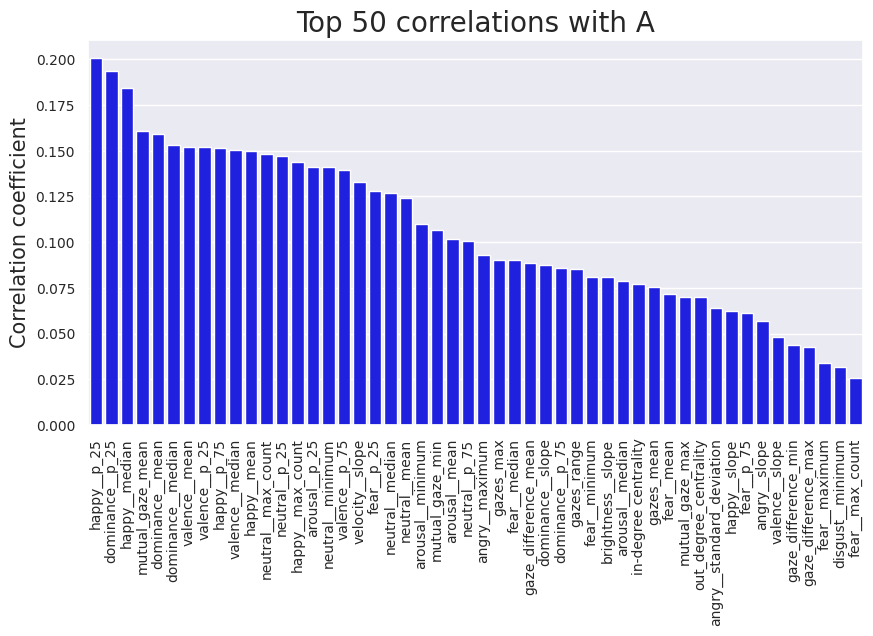

In [42]:
# Concatenate the two dataframes along columns
X.columns = [col.lower() for col in X.columns]
X.rename(columns={'degree centrality': 'out_degree_centrality'}, inplace=True)
X.rename(columns=lambda x: x.split('_')[0].replace('gazedifference', 'gaze_difference') + '_' + x.split('_')[1] if 'gazedifference_' in x else x, inplace=True)
X.rename(columns=lambda x: x.split('_')[0].replace('mutualgaze', 'mutual_gaze') + '_' + x.split('_')[1] if 'mutualgaze' in x else x, inplace=True)

data = pd.concat([X, Y], axis=1)

# Compute the correlation matrix
correlation_matrix = data.corr()

# For each target dimension, get the 10 highest correlation coefficients from the features
for target in Y.columns:
    correlations = correlation_matrix[target].drop(index=Y.columns)  # drop the correlations with other targets
    top_correlations = correlations.nlargest(50)  # Get top 10 largest correlations

    # Plot the top 10 correlations
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_correlations.index, y=top_correlations.values, color="blue")
    plt.title(f"Top 50 correlations with {target}", fontsize=20)
    plt.ylabel("Correlation coefficient", fontsize=15)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=10)
    
    path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/appendix/"
    image = path + "/" + target.lower() + "_correlations.pdf"
    plt.savefig(image, bbox_inches='tight', dpi=300)

In [11]:
# from sklearn.neighbors import LocalOutlierFactor
# # define the model
# print(X.shape)
# lof = LocalOutlierFactor(contamination=0.05)
# # fit the model
# yhat = lof.fit_predict(X)

# # select all rows that are not outliers
# mask = yhat != -1
# X = X[mask]
# Y = Y[mask]
# print(X.shape)

In [12]:
# Scale Features
# Create a MinMaxScaler object
minmax_scaler = MinMaxScaler()
gaussian_scaler = StandardScaler()
non_gaussian_scaler = RobustScaler()

# Calculate skewness of each feature
skewness = skew(X, axis=0)

# Create empty list to store scaled features
scaled_features = []

# Scale features using appropriate scaler
for feat, s in zip(X.columns, skewness):
    if abs(s) < 0.5:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    scaled_feat = scaler.fit_transform(X[feat].values.reshape(-1, 1)).flatten()
    scaled_features.append(pd.Series(scaled_feat, name=feat))

# Concatenate scaled features into new DataFrame
scaled_X = pd.concat(scaled_features, axis=1)


# Fit the scaler to the dataframe and transform the dataframe
scaled_Y = Y

In [13]:
def assign_class_based_on_median(df):
    # Select only numerical columns
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Calculate the median value of all numerical values in the DataFrame
    median_value = df[numeric_columns].stack().median()

    # Define a helper function to classify values based on the median value
    def classify(value):
        if value < median_value:
            return 0
        else:
            return 1

    # Apply the helper function to each numerical value in the DataFrame
    for col in numeric_columns:
        df[col] = df[col].apply(classify)

    return df

# Assign each numerical value to either class 0 or class 1
scaled_Y = assign_class_based_on_median(scaled_Y)
#print(scaled_Y["E"].value_counts())


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# # Convert the DataFrames to NumPy arrays
# X_np = scaled_X.to_numpy()
# Y_np = scaled_Y.to_numpy()

# # Perform the train/test split
# X_train_np, y_train_np, X_test_np, y_test_np = iterative_train_test_split(X_np, Y_np, test_size=0.2)

# # Convert the NumPy arrays back to DataFrames
# X_train = pd.DataFrame(X_train_np, columns=scaled_X.columns)
# Y_train = pd.DataFrame(y_train_np, columns=scaled_Y.columns)
# X_test = pd.DataFrame(X_test_np, columns=scaled_X.columns)
# Y_test = pd.DataFrame(y_test_np, columns=scaled_Y.columns)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, scaled_Y, test_size=0.2, random_state=42)

In [16]:
# # Calculate correlation matrix
# corr_matrix = X_train.corr().abs()

# # Create a DataFrame from the correlation matrix
# corr_df = corr_matrix.unstack().reset_index()

# # Rename columns
# corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# # Remove self correlations by excluding cases where variables are correlated with themselves
# corr_df = corr_df[corr_df['Feature1'] != corr_df['Feature2']]

# # Drop duplicates
# corr_df = corr_df.drop_duplicates()

# # Sort by absolute correlation
# corr_df['AbsCorrelation'] = np.abs(corr_df['Correlation'])
# corr_df.sort_values(by='AbsCorrelation', ascending=False, inplace=True)

# # Identify highly correlated feature pairs
# high_corr_pairs = []
# for index, row in corr_df.iterrows():
#     if row['AbsCorrelation'] > 0.8:
#         high_corr_pairs.append((row['Feature1'], row['Feature2']))

# # From each pair, remove the feature with lower average correlation
# to_drop = set()
# for pair in high_corr_pairs:
#     feature1_avg_corr = corr_df[(corr_df['Feature1'] == pair[0]) | (corr_df['Feature2'] == pair[0])]['AbsCorrelation'].mean()
#     feature2_avg_corr = corr_df[(corr_df['Feature1'] == pair[1]) | (corr_df['Feature2'] == pair[1])]['AbsCorrelation'].mean()

#     if feature1_avg_corr < feature2_avg_corr:
#         to_drop.add(pair[0])
#     else:
#         to_drop.add(pair[1])

# # Drop highly correlated features from original dataframe
# for feature in to_drop:
#     if feature in X_train.columns:
#         X_train = X_train.drop(columns=[feature])

# print(X_train)

In [17]:
# Check the class distributions in the train and test sets
print("Train set class distribution:")
for col in scaled_Y.columns:
    print(f"{col}: {Y_train[col].mean()}")

print("\nTest set class distribution:")
for col in scaled_Y.columns:
    print(f"{col}: {Y_test[col].mean()}")

Train set class distribution:
P: 0.4878048780487805
E: 0.4634146341463415
R: 0.5853658536585366
M: 0.5365853658536586
A: 0.5975609756097561

Test set class distribution:
P: 0.47619047619047616
E: 0.5238095238095238
R: 0.5238095238095238
M: 0.47619047619047616
A: 0.5714285714285714


In [18]:
def get_selected_voting_features_combined(Y, X, filter_methods, wrapper_methods, k):
    
    feature_counts = np.zeros(X.shape[1])

    # Apply filter methods
    for _, method in filter_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        print(len(selected_i))
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1

    # Apply wrapper methods
    for _, method in wrapper_methods.items():
        method.fit(X, Y)
        selected_i = method.get_support(indices=True)
        
        # Increment the count for each selected feature
        for index in selected_i:
            feature_counts[index] += 1
    
    # Get the indices of the top k features with the most counts
    #selected_features = np.argsort(feature_counts)[-k:]
    selected_features = np.where(feature_counts >= k)[0]
    print(np.sort(feature_counts))
    
    return selected_features

In [19]:
np.random.seed(42)

# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": None,
    "E": None,
    "R": None,
    "M": None,
    "A": None,
}

filter_methods = {
    #'chi2': SelectKBest(chi2, k=8),
    'f_classif': SelectKBest(f_classif, k=8),
    'mutual_info_classif': SelectKBest(mutual_info_classif, k=8),
    'variance_threshold': VarianceThreshold(threshold=2.0),
    'select_percentile': SelectPercentile(f_classif, percentile=10),
    'select_fpr': SelectFpr(f_classif, alpha=0.15),
    'select_fdr': SelectFdr(f_classif, alpha=0.915),
    'select_fwe': SelectFwe(f_classif, alpha=1.0),
    #'rfe_classification': RFEC(LogisticRegression(), n_features_to_select=8),
}

wrapper_methods = {
    #'sfs_classification': SequentialFeatureSelector(LogisticRegression(), n_features_to_select=8, direction='forward', n_jobs=-1),
    #'sbs_classification': SequentialFeatureSelector(LogisticRegression(), n_features_to_select=8, direction='backward', n_jobs=-1),
}

# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features_combined(Y_train.iloc[:, i], X_train, filter_methods, wrapper_methods, k=4)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print(pillar, ":", perma_dict[pillar])

8
8
24
13
15
68
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4.
 4. 4.]
8
8
24
13
26
70
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4.
 5. 5.]
8
8
24
13
29
112
4
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

In [20]:
feature_sets = {
    "P": {"train": None, "test": None},
    "E": {"train": None, "test": None},
    "R": {"train": None, "test": None},
    "M": {"train": None, "test": None},
    "A": {"train": None, "test": None}
}

for perma_dim, selected_features in perma_dict.items():
    # Select the corresponding columns of X_filtered
    X_train_final = X_train.iloc[:, list(set(selected_features))]
    #X_test_final = X_test.iloc[:, list(set(selected_features))]
    column_names = X_train_final.columns.tolist()
    X_test_final = X_test[column_names]
    # Add the selected features for the current PERMA dimension to the feature sets dictionary
    feature_sets[perma_dim]["train"] = X_train_final
    feature_sets[perma_dim]["test"] = X_test_final
    # Print the names of the selected features
    column_names = X_train_final.columns.tolist()
    print(perma_dim, ":", column_names)

P : ['angry__minimum', 'surprise__minimum', 'out_degree_centrality', 'dominance__minimum', 'neutral__standard_deviation', 'neutral__maximum', 'brightness__maximum', 'happy__slope', 'velocity__median']
E : ['sad__max_count', 'dominance__median', 'gazes_mean', 'gazes_min', 'brightness__maximum', 'sad__median', 'sad__mean', 'valence__median', 'velocity__minimum', 'sad__p_25']
R : ['angry__minimum', 'brightness__median', 'brightness__mean', 'brightness__maximum', 'happy__slope', 'brightness__p_25', 'brightness__p_75', 'velocity__median', 'velocity__p_75']
M : ['surprise__median', 'surprise__mean', 'arousal__median', 'surprise__minimum', 'fear__max_count', 'surprise__p_25', 'surprise__p_75', 'dominance__slope', 'neutral__maximum', 'valence__slope']
A : ['arousal__standard_deviation', 'arousal__minimum', 'dominance__p_25', 'happy__median', 'happy__p_25', 'sad__standard_deviation', 'sad__p_75', 'valence__p_75']


In [21]:
SAVE_DIR_CLASSIFIER = Path("/home/moritz/Workspace/masterthesis/model/custom_models/classifier/small")

eval_metric = "accuracy"

In [22]:
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

random_state = 0

CLASSIFIER = [
    {
        "name": "MLPClassifier",
        "model": MLPClassifier(max_iter=2000),
        "params": {
            "hidden_layer_sizes": [(64, 32), (128, 64)],
            "alpha": [0.001, 0.01, 0.1],
            "learning_rate_init": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "KNeighborsClassifier",
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [1, 5, 10, 15, 20]},
    },
    {
        "name": "DecisionTreeClassifier",
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": range(2, 11),
            "random_state": [random_state],
        },
    },
    {
        "name": "RandomForestClassifier",
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "class_weight": ["balanced", "balanced_subsample"],
            "random_state": [random_state],
        },
    },
    {
        "name": "ExtraTreesClassifier",
        "model": ExtraTreesClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "class_weight": ["balanced", "balanced_subsample"],
            "random_state": [random_state],
        },
    },
    {
        "name": "GradientBoostingClassifier",
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "AdaBoostClassifier",
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "learning_rate": [0.001, 0.01, 0.1],
            "random_state": [random_state],
        },
    },
    {
        "name": "SVC",
        "model": SVC(),
        "params": {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1.0, 10.0],
            "shrinking": [True, False],
            "class_weight": ["balanced"],
            "random_state": [random_state],
        },
    },
    # 160/300 fits fails, because the grid search is exhaustive!
    {
        "name": "LogisticRegression",
        "model": LogisticRegression(max_iter=2000),
        "params": {
            "C": [0.001, 0.01, 0.1, 1.0],
            "penalty": ["l1", "l2", "elasticnet"],
            "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
            "class_weight": ["balanced"],
            "random_state": [random_state],
        },
    },
    {
        "name": "RidgeClassifier",
        "model": RidgeClassifier(),
        "params": {
            "alpha": [0.001, 0.01, 0.1, 1.0],
            "class_weight": ["balanced"],
            "random_state": [random_state],
        },
    },
    {
        "name": "GaussianNB",
        "model": GaussianNB(),
        "params": {"var_smoothing": [1e-9, 1e-8, 1e-7]},
    },
    {
        "name": "CatBoostClassifier",
        "model": CatBoostClassifier(verbose=False),
        "params": {
            "iterations": [50, 100, 500, 1000],
            "depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1, 1.0],
            "auto_class_weights": ["Balanced", "SqrtBalanced"],
            "random_state": [random_state],
        },
    },
    {
        "name": "XGBClassifier",
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 400],
            "max_depth": range(2, 6),
            "learning_rate": [0.001, 0.01, 0.1],
            "scale_pos_weight": [1, 50, 99, 1000],
            "random_state": [random_state],
        },
    },
]

In [23]:
classifier_to_drop = ["MLPClassifier", "GaussianNB", "LogisticRegression", "AdaBoostClassifier", "SVC"]

for name in classifier_to_drop:
    for i in range(len(CLASSIFIER)):
        if CLASSIFIER[i]["name"] == name:
            del CLASSIFIER[i]
            break
        
for classifier in CLASSIFIER:
    print(classifier["name"])

KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier
RidgeClassifier
CatBoostClassifier
XGBClassifier


In [24]:
results_classifier_dict = {}

for perma_dim, X_final in feature_sets.items():
    print(f"PERMA dimension: {perma_dim}")
    # Run the hyperparameter search
    models_path = SAVE_DIR_CLASSIFIER / perma_dim
    X_train = X_final["train"]
    search = HyperparaSearchClassifier(models=CLASSIFIER, metrics=["accuracy"], models_path = models_path, n_folds=5, n_jobs=-1, mode="uni")  
    results = search.run(X_train, Y_train[perma_dim], save=True)
    results_classifier_dict[perma_dim] = results
    # Print the model with the lowest score
    best_model = min(
        [
            min(
                sublist,
                key=lambda x: x["score"]
                if x["metric"] == eval_metric
                else float("inf"),
            )
            for sublist in results
        ],
        key=lambda x: x["score"],
    )
    print(perma_dim)
    print(f"Best model: {best_model['name']}")
    print(f"Best params: {best_model['params']}")
    print(f"Best Score: {best_model['score']}")

PERMA dimension: P
Models for KNeighborsClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/small/P/KNeighborsClassifier.joblib
Models for DecisionTreeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/small/P/DecisionTreeClassifier.joblib
Models for RandomForestClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/small/P/RandomForestClassifier.joblib
Models for ExtraTreesClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/small/P/ExtraTreesClassifier.joblib
Models for GradientBoostingClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/small/P/GradientBoostingClassifier.joblib
Models for RidgeClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/small/P/RidgeClassifier.joblib
Models for CatBoostClassifier saved to /home/moritz/Workspace/masterthesis/model/custom_models/classifier/s

In [25]:
results_classifier_dict

{'P': [[{'name': 'KNeighborsClassifier',
    'params': {'n_neighbors': 20},
    'metric': 'accuracy',
    'score': 0.5632352941176471,
    'model': GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                 estimator=KNeighborsClassifier(),
                 param_grid={'n_neighbors': [1, 5, 10, 15, 20]},
                 scoring='accuracy')}],
  [{'name': 'DecisionTreeClassifier',
    'params': {'max_depth': 2, 'random_state': 0},
    'metric': 'accuracy',
    'score': 0.5147058823529411,
    'model': GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                 estimator=DecisionTreeClassifier(),
                 param_grid={'max_depth': range(2, 11), 'random_state': [0]},
                 scoring='accuracy')}],
  [{'name': 'RandomForestClassifier',
    'params': {'class_weight': 'balanced_subsample',
     'max_depth': 2,
     'n_estimators': 100,
     'random_state': 0},
    'metric': 'accuracy',
    'score': 0.5639705882352941,
    'model

In [26]:
best_models = {}

for perma_dim, results in results_classifier_dict.items():
    flattened_results = [item for sublist in results for item in sublist]
    best_model = max(flattened_results, key=lambda x: x['score'])
    #if perma_dim == "P":
    #    best_models[perma_dim] = "DecisionTreeClassifier"
    # print(perma_dim)
    # print(f"Best model: {best_model['name']}")
    # print(f"Best params: {best_model['params']}")
    # print(f"Best Score: {best_model['score']}")
    #else:
    best_models[perma_dim] = best_model['name']

In [27]:
best_models

{'P': 'CatBoostClassifier',
 'E': 'CatBoostClassifier',
 'R': 'ExtraTreesClassifier',
 'M': 'CatBoostClassifier',
 'A': 'CatBoostClassifier'}

In [28]:
def load_best_model(file_path: Path):

    models = {}

    if file_path.is_file():
        model = joblib.load(file_path)

        models[str(file_path.stem)] = model

    return models

In [29]:
perma_models = {}

for perma_dim in ["P", "E", "R", "M", "A"]:
    models_path = SAVE_DIR_CLASSIFIER / perma_dim / (best_models[perma_dim] + ".joblib")
    models = load_best_model(models_path)
    perma_models[perma_dim] = models

In [30]:
def print_models(models, X, y):
    # Generate and return a dictionary of mean absolute error (MAE) scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        if model_name == "CatBoostClassifier":
            print(model.get_params())
        else:
            print(model)
        
for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    print_models(models, X_test, Y_test[dim])

{'iterations': 50, 'learning_rate': 0.1, 'depth': 3, 'verbose': False, 'auto_class_weights': 'Balanced', 'random_state': 0}
{'iterations': 50, 'learning_rate': 0.01, 'depth': 4, 'verbose': False, 'auto_class_weights': 'SqrtBalanced', 'random_state': 0}
ExtraTreesClassifier(class_weight='balanced', max_depth=2, random_state=0)
{'iterations': 50, 'learning_rate': 0.1, 'depth': 2, 'verbose': False, 'auto_class_weights': 'Balanced', 'random_state': 0}
{'iterations': 50, 'learning_rate': 0.01, 'depth': 2, 'verbose': False, 'auto_class_weights': 'Balanced', 'random_state': 0}


In [31]:
def generate_predictions(models, X, y):
    # Generate and return a dictionary of balanced accuracy scores and prediction arrays for each model
    results = {}
    for model_name, mae_grid_search in models.items():
        # Fit the model
        model = mae_grid_search[0].best_estimator_
        # Make predictions
        y_pred = model.predict(X)
        # Calculate balanced accuracy score
        balanced_accuracy = balanced_accuracy_score(y, y_pred)
        results[model_name] = {"accuracy": balanced_accuracy, "y_pred": y_pred}
    return results


In [32]:
def generate_shap_values_and_ranks(dim, models, X):
    feature_rankings = {}

    for i, (model_name, mae_grid_search) in enumerate(models.items()):
        model = mae_grid_search[0].best_estimator_
        print(model_name)

        if model_name in ["LogisticRegression", "RidgeClassifier"]:
            explainer = shap.LinearExplainer(model, X, feature_names=X.columns)
        elif model_name in ["AdaBoostClassifier", "GaussianNB", "KNeighborsClassifier", "DecisionTreeClassifier", "SVC", "ExtraTreesClassifier", "RandomForestClassifier"]:
            explainer = shap.SamplingExplainer(model.predict, X)
        elif model_name in []:
            explainer = shap.KernelExplainer(model.predict, X)
        elif model_name in ["CatBoostClassifier"]:
            explainer = shap.Explainer(model, feature_names=X.columns)
        else:
            explainer = shap.TreeExplainer(model, feature_names=X.columns)

        shap_values = explainer(X)
        shap.summary_plot(shap_values, X, plot_size=(13, 3), plot_type='violin', show=False)
        path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results/small_classif_shap"
        image = path + "/" + dim[i].lower() + "_small_classif.pdf"
        plt.savefig(image, bbox_inches='tight', dpi=300)
        plt.close()  # close the plot

        # Get the mean absolute shap values for each feature
        mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

        # Create a DataFrame for easy sorting and manipulation
        feature_shap_df = pd.DataFrame(list(zip(X.columns, mean_abs_shap_values)), 
                                       columns=['feature','mean_abs_shap'])

        # Sort by the mean absolute shap value and add rank column
        feature_shap_df = feature_shap_df.sort_values('mean_abs_shap', ascending=False)
        feature_shap_df['rank'] = range(1, len(feature_shap_df) + 1)
        
        # Store the ranking in the dictionary
        feature_rankings[model_name] = feature_shap_df[['feature', 'rank']].set_index('feature').to_dict()['rank']

    return feature_rankings

def aggregate_ranks(feature_rankings_perma):
    aggregated_ranks = {}
    for dim, feature_rankings in feature_rankings_perma.items():
        # Calculate the total rank and count for each feature
        total_ranks = {}
        counts = {}
        for model_name, ranks in feature_rankings.items():
            for feature, rank in ranks.items():
                if feature in total_ranks:
                    total_ranks[feature] += rank
                    counts[feature] += 1
                else:
                    total_ranks[feature] = rank
                    counts[feature] = 1

        # Calculate the mean rank for each feature
        mean_ranks = {feature: total_ranks[feature] / counts[feature] for feature in total_ranks}

        # Sort the features by their mean ranks
        sorted_features = sorted(mean_ranks, key=mean_ranks.get)
        aggregated_ranks[dim] = sorted_features

    return aggregated_ranks


In [33]:
feature_rankings_perma = {}
for dim, models in perma_models.items():
    print(dim)
    X_test = feature_sets[dim]["train"]
    X_test.columns = [col.lower() for col in X_test.columns]
    X_test.rename(columns={'degree centrality': 'out_degree_centrality'}, inplace=True)
    X_test.rename(columns=lambda x: x.split('_')[0].replace('mutualgaze', 'mutual_gaze') + '_' + x.split('_')[1] if 'mutualgaze_' in x else x, inplace=True)
    
    feature_rankings_perma[dim] = generate_shap_values_and_ranks(dim, models, X_test)

aggregated_ranks = aggregate_ranks(feature_rankings_perma)

P
CatBoostClassifier


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


E
CatBoostClassifier


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names


R
ExtraTreesClassifier


  0%|          | 0/82 [00:00<?, ?it/s]X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
X does not have valid feature names, but E

M
CatBoostClassifier


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


A
CatBoostClassifier


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [34]:
def calculate_importance(feature_rankings_perma):
    # Initialize total ranks and counts dictionaries
    total_ranks = {}
    counts = {}

    # Iterate over all dimensions
    for dim, feature_rankings in feature_rankings_perma.items():
        # Iterate over all features in this dimension
        for rank, feature in enumerate(feature_rankings, 1):
            # Update total ranks and counts
            if feature in total_ranks:
                val = 1.1 - 0.1*rank
                total_ranks[feature] += val
                counts[feature] += 1
            else:
                val = 1.1 - 0.1*rank
                total_ranks[feature] = val
                counts[feature] = 1


    # Calculate the average rank for each feature
    #avg_ranks = {feature: total_ranks[feature] / counts[feature] for feature in total_ranks}

    return counts, total_ranks

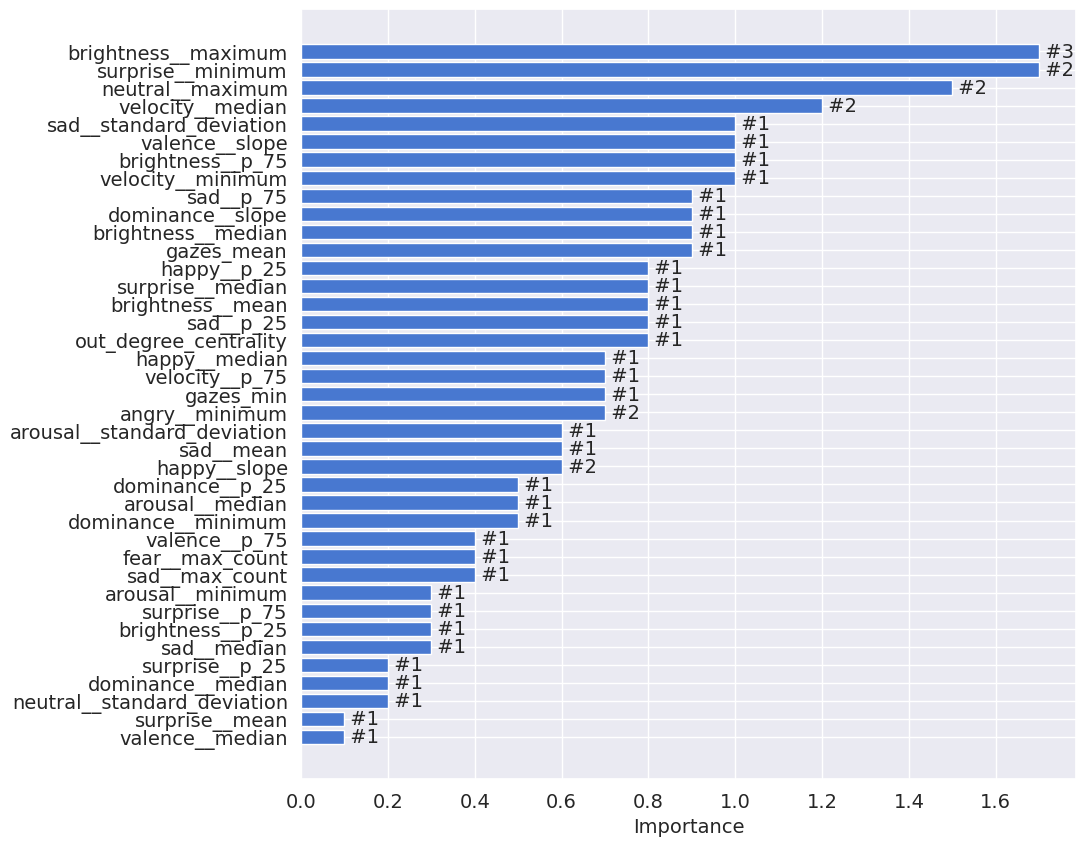

In [35]:
# Apply your function to the data
counts, total_ranks = calculate_importance(aggregated_ranks)

# Sort the dictionary by value
sorted_importance = sorted(total_ranks.items(), key=lambda item: item[1])

# Unpack names and values
names, values = zip(*sorted_importance)

# Create a color palette
palette = sns.color_palette("muted")

fig, ax = plt.subplots(figsize=(10, 10))

# Apply color palette
ax.set_prop_cycle(color=palette)

# Create a horizontal bar plot
ax.barh(names, values)

# Add counts on top of the bars
for i, name in enumerate(names):
    count = counts[name]
    value = values[i]
    ax.text(value, i, f' #{count}', va='center', fontsize=14)  # increase fontsize here

ax.set_xlabel('Importance', fontsize=14)  # increase fontsize here
plt.yticks(fontsize=14) 
plt.xticks(fontsize=14) 

path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/imp_classif.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)

In [36]:
perma_results = {}

for dim, models in perma_models.items():
    X_test = feature_sets[dim]["test"]
    results = generate_predictions(models, X_test, Y_test[dim])
    perma_results[dim] = results

In [37]:
best_results = {}

for dim, results in perma_results.items():
    curr_mae = float("inf")
    for model in results:
        if results[model]["accuracy"] < curr_mae:
            curr_mae = results[model]["accuracy"]
            best_results[dim] = {"model": model, "accuracy": results[model]["accuracy"], "preds": results[model]["y_pred"]}
            
print(best_results)

{'P': {'model': 'CatBoostClassifier', 'accuracy': 0.5136363636363637, 'preds': array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])}, 'E': {'model': 'CatBoostClassifier', 'accuracy': 0.6181818181818182, 'preds': array([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])}, 'R': {'model': 'ExtraTreesClassifier', 'accuracy': 0.6136363636363636, 'preds': array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1])}, 'M': {'model': 'CatBoostClassifier', 'accuracy': 0.38181818181818183, 'preds': array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1])}, 'A': {'model': 'CatBoostClassifier', 'accuracy': 0.5, 'preds': array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1])}}


In [38]:
# Baseline:
accuracy_baseline = [0.5, 0.5, 0.5, 0.5, 0.5]

print(f"Baseline accuracy for each dimension: {accuracy_baseline}")

Baseline accuracy for each dimension: [0.5, 0.5, 0.5, 0.5, 0.5]


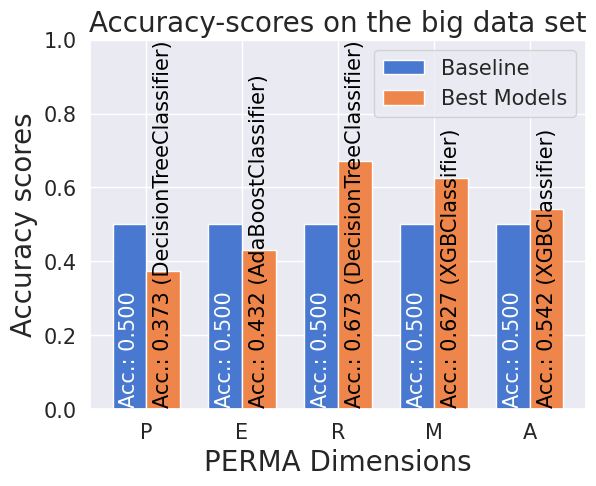

In [39]:
# Print the best model for each PERMA dimension
best_accuracy_values = [v['accuracy'] for v in best_results.values()]
#best_accuracy_values = [0.373, 0.432, 0.673, 0.627, 0.542]
#models = ["DecisionTreeClassifier", "AdaBoostClassifier", "DecisionTreeClassifier", "XGBClassifier", "XGBClassifier"]

# Define the x-axis labels and the bar width
perma_dimensions = ['P', 'E', 'R', 'M', 'A']
bar_width = 0.35

# Set up the plot
fig, ax = plt.subplots()
palette = sns.color_palette("muted")
ax.set_prop_cycle(color=palette)
ax.bar(np.arange(len(perma_dimensions)), accuracy_baseline, width=bar_width, label='Baseline')
ax.bar(np.arange(len(perma_dimensions))+bar_width, best_accuracy_values, width=bar_width, label='Best Models')

# Set the x-axis ticks and labels
ax.set_xticks(np.arange(len(perma_dimensions))+bar_width/2)
ax.set_xticklabels(perma_dimensions)
ax.set_xlabel('PERMA Dimensions', fontsize=20)

# Set the y-axis label and limits
ax.set_ylabel('Accuracy scores', fontsize=20)
ax.set_ylim([0, max(np.max(accuracy_baseline), np.max(best_accuracy_values))*1.1])
ax.tick_params(axis='both', which='major', labelsize=15)

# Add the model names and MAE values above each bar
for i, v in enumerate(accuracy_baseline):
    ax.text(i, 0.005, f"Acc.: {v:.3f}", rotation=90, ha='center', va='bottom', fontsize=15, color='white')
    model = best_results[perma_dimensions[i]]['model']
    #model = models[i]
    ax.text(i+bar_width, 0.005, f"Acc.: {best_accuracy_values[i]:.3f} ({model})", rotation=90, ha='center', va='bottom', fontsize=15, color='black')

# Add a legend and title
ax.legend(fontsize=15)
ax.set_title('Accuracy-scores on the small data set', fontsize=20)
ax.set_ylim([0, 1.0])

path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/accur_small.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)